# About the project
The end goal of this project is to classify patients with high protein concentration in urine and the healthy group based on SERS (Surface Enchanced Raman Spectroscopy) spectral data and biomedical data.  
This project is to be released as a research paper later in 2022 or 2023. Some information might not be fully shown here as a result.

The project is divided into several Jupyter notebooks with the following names:
1) Import raw urine spectra (part 1)
2) Spectra processing (part 2)
3) Classification of patients (part 3)
4) Biomedical data (part 4)
5) Comparison of nanoparticles (part 5)

Author of all codes: Sultan Aitekenov, sultanaitekenov@gmail.com

Part of the upcoming abstract:
Excessive protein excretion in human urine is an early and sensitive marker of diabetic nephropathy, primary and secondary renal disease. Kidney problems, particularly chronic kidney disease, remain among the few growing causes of mortality in the world. Therefore, it is important to develop efficient, expressive, and low-cost method for protein determination. Surface enhanced Raman spectroscopy (SERS) methods are potential candidates to achieve those criteria. In this paper, the SERS methods was developed to distinguish patients with proteinuria and the healthy group. Commercial gold nanoparticles with the diameter of 60 nm and 100 nm, and silver nanoparticles with the diameter of 100 nm were employed. Silver, gold, silicon and test slides covered with aluminium tape were utilized as substrates. Obtained spectra were analysed with several machine learning algorithms coupled with the PCA, ROC curve, and cross-validation methods. 

# Classification of patients (part 3)

## Import data

### Import modules

In [1]:
# other modules related to classification are imported later
import pandas as pd
import numpy as np
import copy
import pickle
import matplotlib.pyplot as plt

### Raman Shift

In [2]:
# Si_60nm_AuNPs is not included though
raman_shift_400_1800=np.array(pd.read_csv('raman_shift_400_1800.csv', header=None))
wave = raman_shift_400_1800[0]

### Processed urine spectra

In [3]:
# data contains a nested dictionary
f = open('processed_urine_spectra.pkl', 'rb')
processed_urine_spectra = pickle.load(f)

In [4]:
processed_urine_spectra.keys()

dict_keys(['Ag_100nm_AgNPs', 'Ag_100nm_AuNPs', 'Al_tape_60nm_AuNPs', 'Al_tape_100nm_AuNPs', 'Au_60nm_AuNPs', 'Au_100nm_AuNPs', 'Si_60nm_AuNPs', 'Au_40nm_AuNPs', 'Au_no_AuNPs', 'Au_HSA_AuNPs', 'glass_no_AuNPs', 'Si_no_AuNPs'])

In [5]:
# delete 'Au_40nm_AuNPs' as it was not used for classification, see part 5
del processed_urine_spectra['Au_40nm_AuNPs']
del processed_urine_spectra['Au_no_AuNPs']
del processed_urine_spectra['Au_HSA_AuNPs']
del processed_urine_spectra['glass_no_AuNPs']
del processed_urine_spectra['Si_no_AuNPs']

### Protein data and health status
Both protein data and health status will be used for labelling. They do not coincide with each other. To get more information about biomedical data see Part 5.

#### Protein data

In [6]:
# protein data
bio_data = pd.read_csv('urine biomedicals processed.csv')
bio_data.head(10)

,Unnamed: 0,status,patient_ID,"volume, L/day",sex,"Potassium, mmole/L","Urea, mmole/L","Uric acid, mmole/L","Protein, mg/L","Sodium, mmole/L","Creatinine, mmole/L",age
0,0,diseased,139,4.84,F,132.10,330.08,4.30,725.206612,91.983471,2.231405,47
1,1,diseased,75,3.42,M,31.10,295.80,2.31,105.263158,93.976608,2.464912,27
2,2,diseased,44,3.40,M,69.02,476.60,3.71,229.411765,141.000000,5.582353,36
3,3,diseased,132,3.38,M,71.60,500.50,4.37,713.017751,111.982249,4.313609,38
4,4,diseased,20,3.28,M,51.40,359.40,NaN,189.024390,117.987805,4.969512,27
5,5,diseased,72,3.16,M,63.20,410.10,3.39,1082.278481,110.000000,4.968354,38
6,6,diseased,31,3.07,M,67.50,258.40,1.98,2915.309446,142.996743,5.504886,42
7,7,diseased,62,3.05,M,66.70,387.60,3.41,527.868852,52.983607,5.213115,38
8,8,diseased,37,3.05,M,46.30,244.00,3.96,4163.934426,134.000000,4.360656,57
9,9,diseased,29,2.90,F,83.80,385.40,0.01,3082.758621,152.000000,2.324138,21


In [7]:
# convert info_protein to dictionary with keys being equal to patients' ID for all patients in the database 
info_protein={}
for i in range(0,len(bio_data)):
    key_ID = bio_data['patient_ID'][i]
    info_protein[key_ID] = float(bio_data['Protein, mg/L'][i]) #converts to mg/L

#### Health status

In [8]:
bio_data['status'].unique()

array(['diseased', 'healthy'], dtype=object)

In [9]:
(bio_data['status'] == 'diseased').sum()

77

In [10]:
(bio_data['status'] == 'healthy').sum()

41

In [11]:
bio_data['status'].count()

118

In [12]:
# health status
health_status={}
for i in range(0,len(bio_data)):
    key_ID = bio_data['patient_ID'][i]
    if bio_data['status'][i] == 'diseased':
        health_status[key_ID] = 1
    elif bio_data['status'][i] == 'healthy':
        health_status[key_ID] = 0

## Assign patients to high or low protein group

### Define function that assigns to high and low protein concentration groups

In [13]:
# function for creation of groups, the same structure as spectra data
def raman_protein_info(input_spectra, input_protein, protein_threshold):
    """
    Compares samples with database. Returns error if match is not found for
    samples. Reports which samples were not included.
    low protein == 0
    high protein == 1
    protein threshold in mg/L
    
    Output file has the same structure as input_spectra
    """
    import copy
    
    # copies the same structure as input spectra
    output_group = copy.deepcopy(input_spectra)
    
    # cycle through expiremntal sets
    for key_set in input_spectra.keys():
        # cycles through patients with key_ID
        for key_ID in input_spectra[key_set].keys():
            # take protein gramm from input_protein
            protein_gramm = input_protein.get(key_ID)
            if protein_gramm == None:
                print(f"error - your protein gramm value is not found in the database for patient {key_ID} in {key_set}")
                # delete patients who is not in the protein database
                output_group[key_set][key_ID] = None
                # del input_spectra[key_set][key_ID]
            elif protein_gramm >= protein_threshold:
                output_group[key_set][key_ID] = 1
            elif protein_gramm <= protein_threshold:
                output_group[key_set][key_ID] = 0
    
    
    output_group_final = output_group
    return output_group_final

### For each experimental set assign to protein groups

In [14]:
# protein is set to 300 mg/L as it is important threshold for medical diagnostics
protein_threshold =  300
groups_protein = raman_protein_info(processed_urine_spectra, info_protein, protein_threshold)
groups_protein;

### Define function that assigns according to the health status

In [15]:
def raman_health_info(input_spectra, health_status):
    """
    Compares samples with database according to their health status.
    diseased == 1
    healthy == 0

    Output file has the same structure as input_spectra
    """
    import copy
    
    # copies the same structure as input spectra
    output_group = copy.deepcopy(input_spectra)
    
    # cycle through expiremntal sets
    for key_set in input_spectra.keys():
        # cycles through patients with key_ID
        for key_ID in input_spectra[key_set].keys():
            
            output_group[key_set][key_ID] = health_status.get(key_ID)

    return output_group

### For each experimental set assign to health status

In [16]:
groups_health = raman_health_info(processed_urine_spectra, health_status)

## Prepare data for x and y training sets

### Select a limited range in raman shift, as it might help to improve classification scores. Uncomment or change status of the cells to Code.

### Convert dictionaries to matrices

In [17]:
# create empty dict
x = {}
y = {}
IDs = {}


for key_set in processed_urine_spectra.keys():
        # create empty matrix to assign to them values later
        matrix_x = []
        matrix_y = []
        matrix_IDs = []
        
        # loop to make dict into matrix
        for key_ID in processed_urine_spectra[key_set].keys():                                                      
            matrix_x.append( processed_urine_spectra[key_set][key_ID] )
            # matrix_y.append( groups_health[key_set][key_ID] )
            matrix_y.append( groups_protein[key_set][key_ID] )
            matrix_IDs.append( int(key_ID) )
            
        # assign matrix to x values    
        x[key_set] = np.array(matrix_x)
        y[key_set] = np.array(matrix_y)
        IDs[key_set] = np.array(matrix_IDs)

## Spectra high vs low protein groups

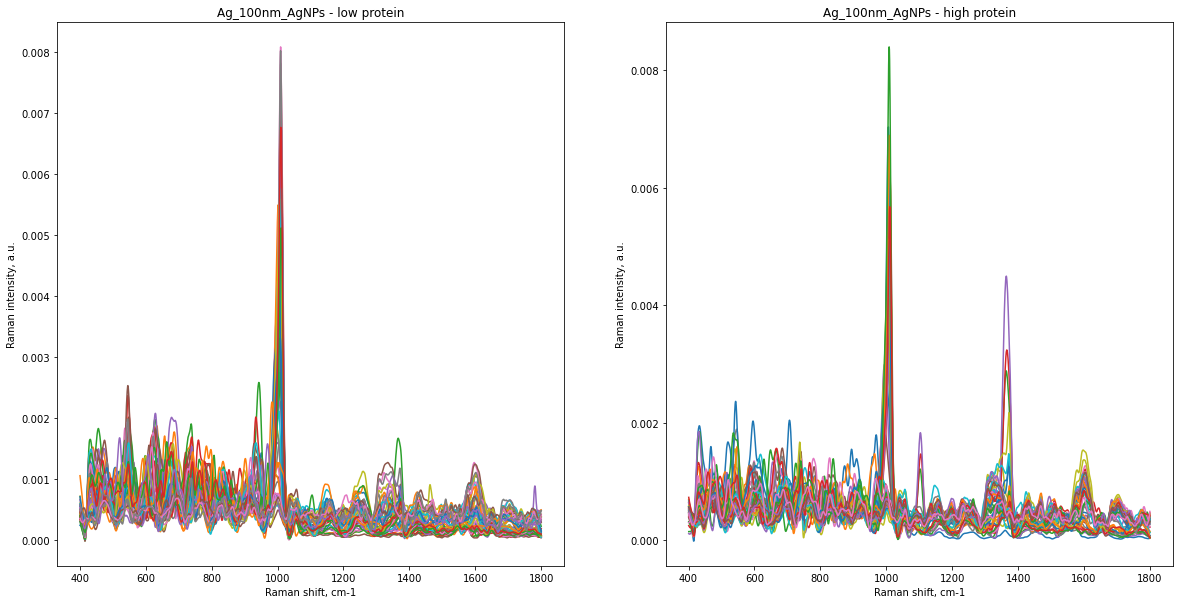

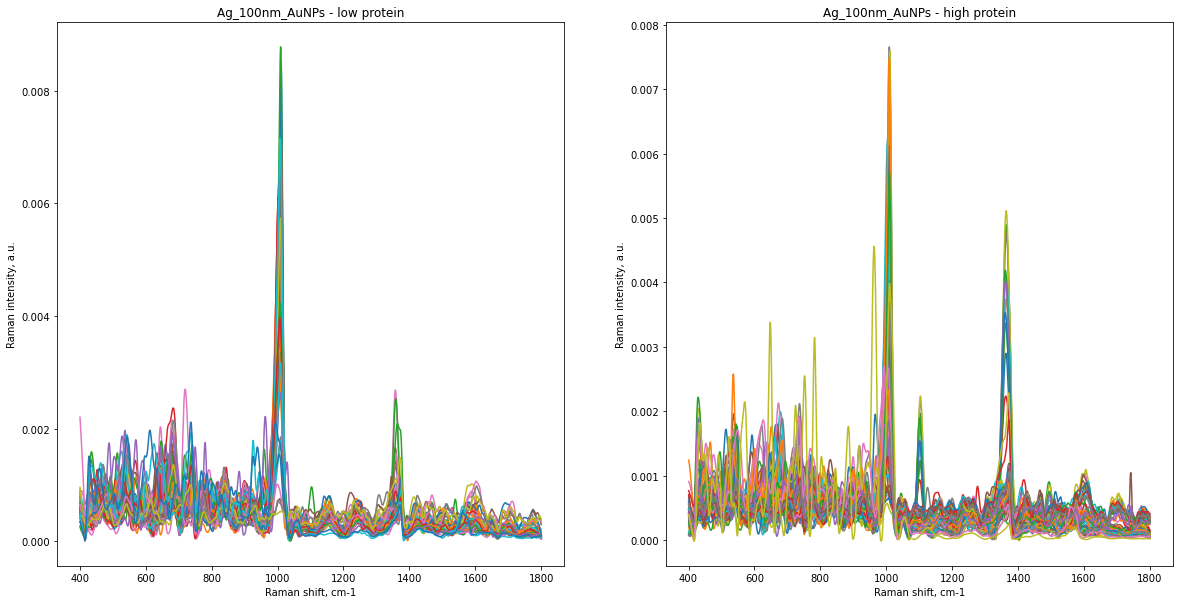

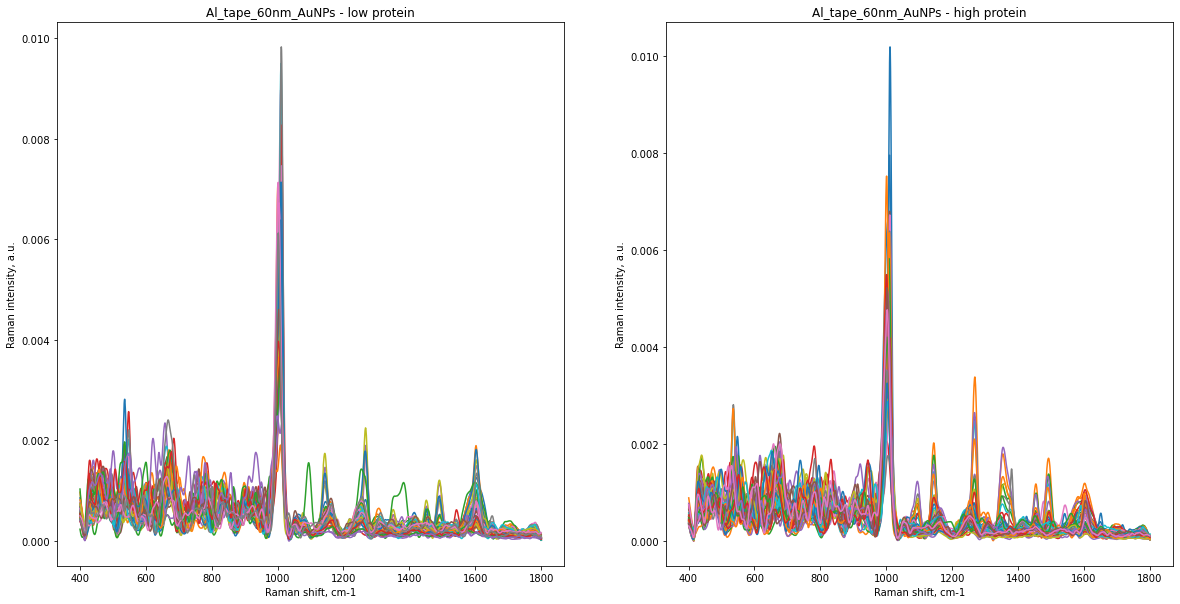

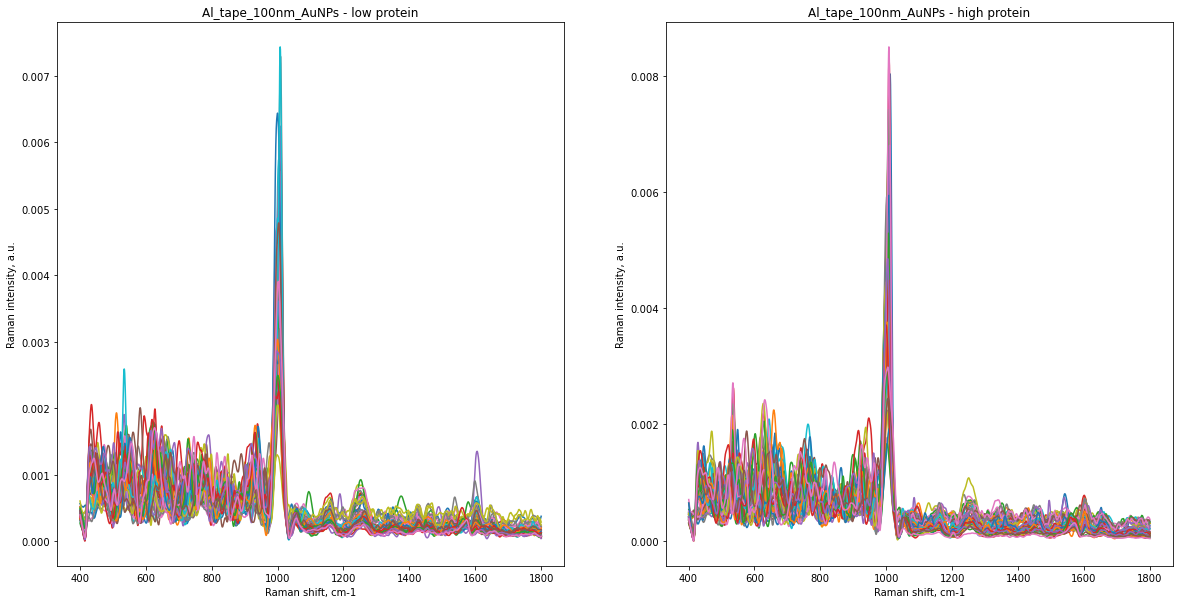

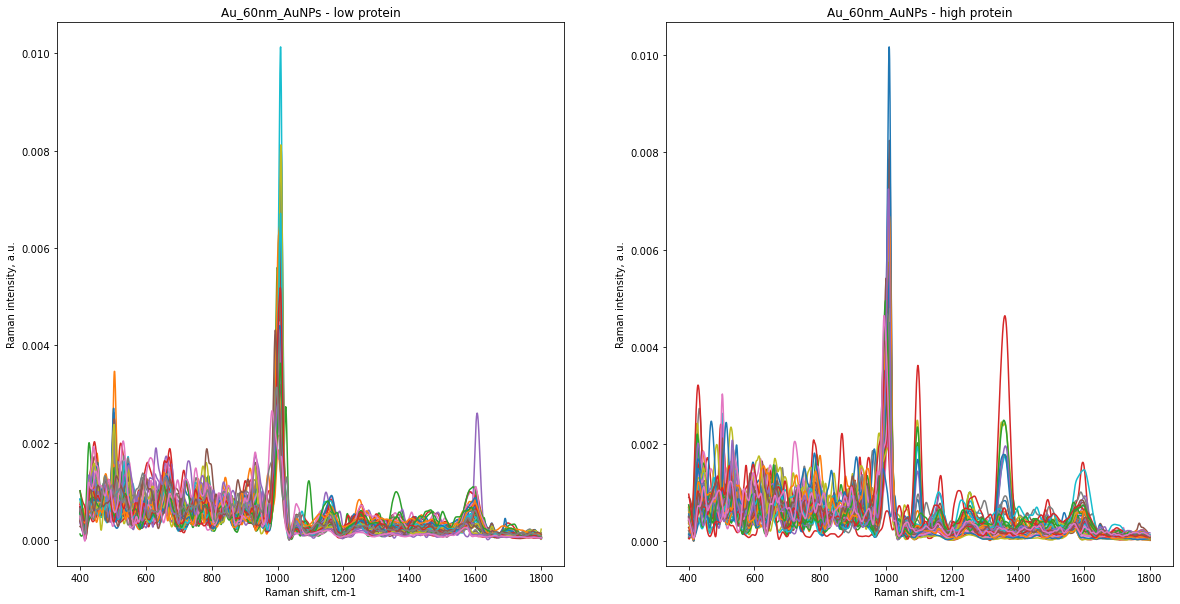

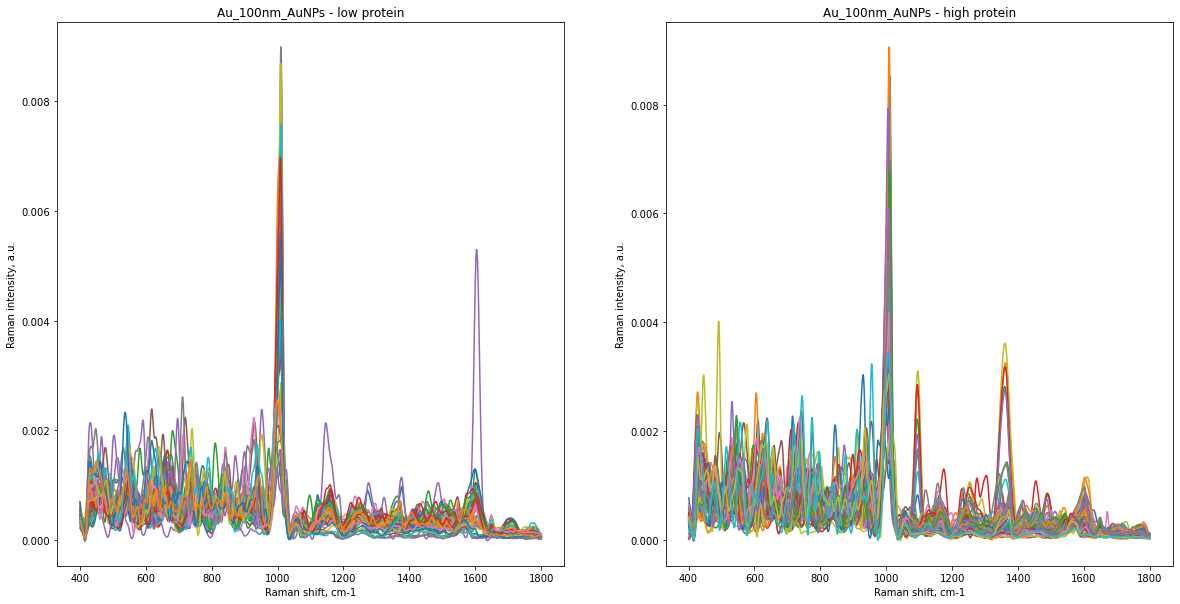

<Figure size 1440x720 with 0 Axes>

In [18]:
# plot spectra of high vs low protein groups for every substrate

for key_set in x.keys():
    plt.figure(figsize =(20,10))
    for i in range(0, len(x[key_set])):
        # low protein
        if y[key_set][i] == 0 and key_set != 'Si_60nm_AuNPs':
            plt.subplot(1,2,1)
            plt.plot(wave, x[key_set][i])
            plt.xlabel('Raman shift, cm-1')
            plt.ylabel('Raman intensity, a.u.')
            plt.title(f'{key_set} - low protein')
        # high protein
        elif y[key_set][i] == 1 and key_set != 'Si_60nm_AuNPs':
            plt.subplot(1,2,2)
            plt.plot(wave, x[key_set][i])
            plt.xlabel('Raman shift, cm-1')
            plt.ylabel('Raman intensity, a.u.')
            plt.title(f'{key_set} - high protein')

### Average spectra

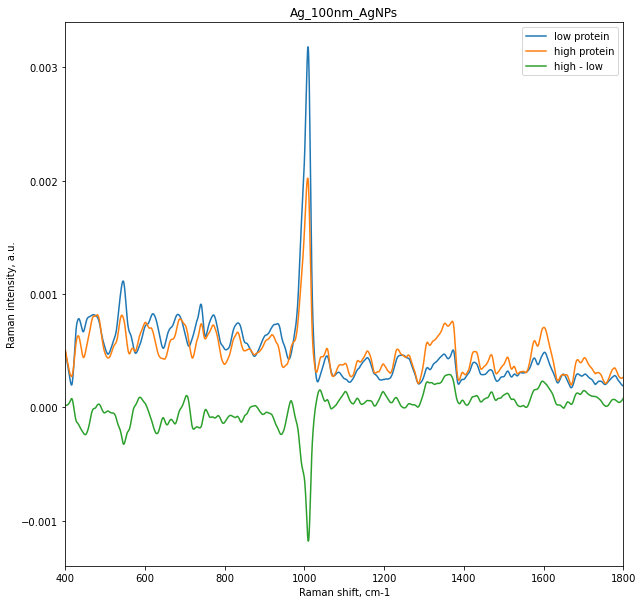

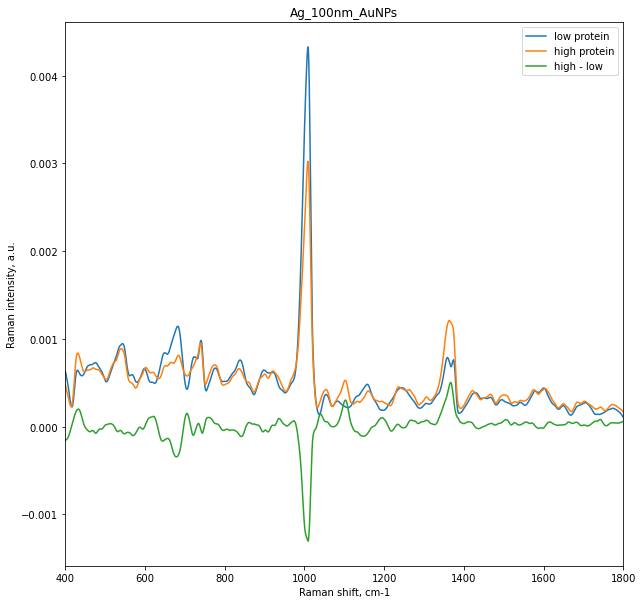

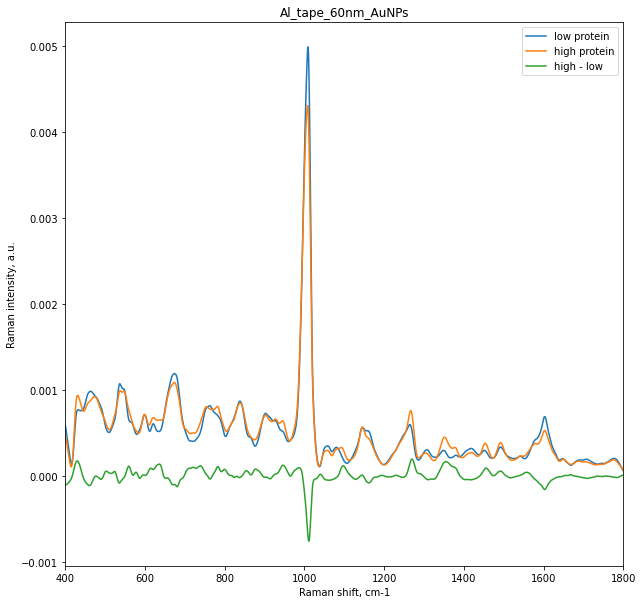

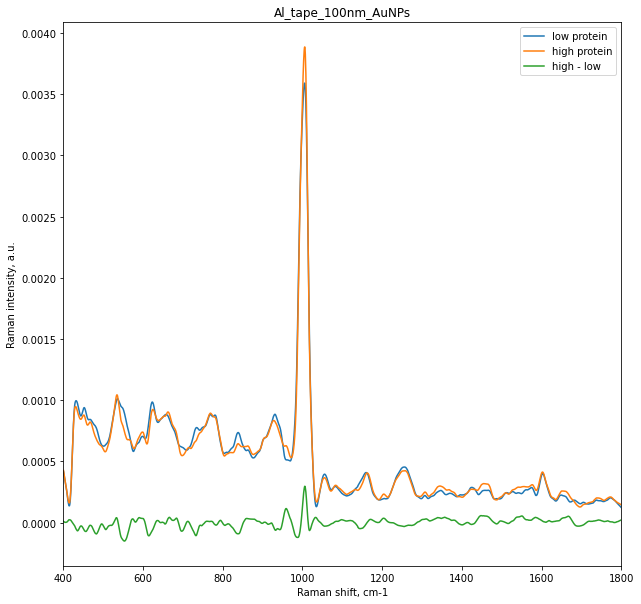

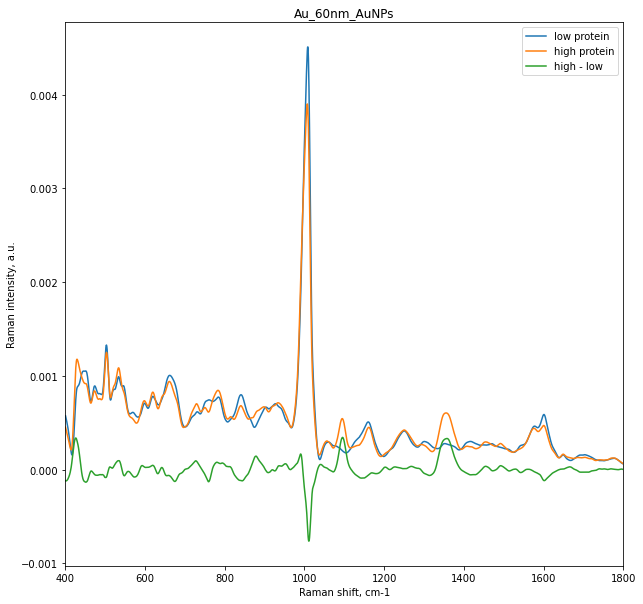

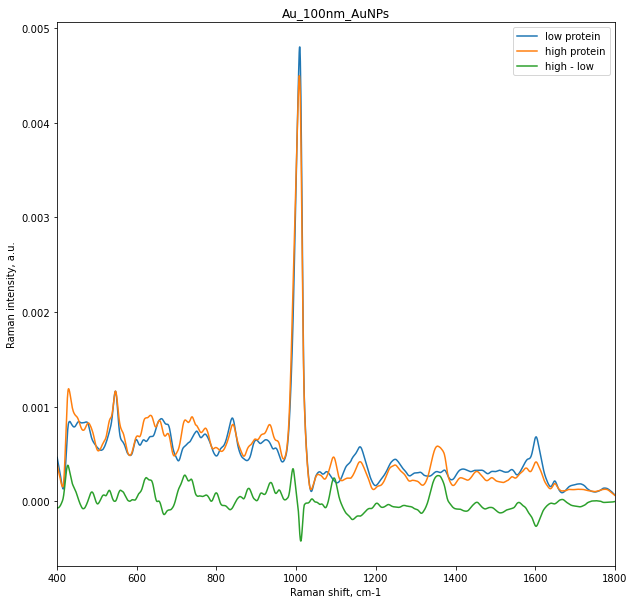

<Figure size 720x720 with 0 Axes>

In [19]:
# plot average spectra of high vs low protein groups for every substrate
x_low = copy.deepcopy(x)
x_high = copy.deepcopy(x)

# create variables that contain mean values
for key_set in x.keys():
    # purge data from x_low and x_high
    x_low[key_set] = np.zeros((2045))
    x_high[key_set] = np.zeros((2045))
    # cycle through patients to categorize in two groups
    for i in range(0, len(x[key_set])):
        # low protein
        if y[key_set][i] == 0 and key_set != 'Si_60nm_AuNPs':
            x_low[key_set] = np.vstack((x_low[key_set], x[key_set][i]))
        # high protein
        elif y[key_set][i] == 1 and key_set != 'Si_60nm_AuNPs':
            x_high[key_set] = np.vstack((x_high[key_set], x[key_set][i]))

 
# create mean values
for key_set in x_low.keys():
    # delete row of zeros
    x_low[key_set] = np.delete(x_low[key_set], 0, axis = 0)
    x_high[key_set] = np.delete(x_high[key_set], 0, axis = 0)
    # create mean afterwards
    x_low[key_set] = np.mean(x_low[key_set], axis = 0)
    x_high[key_set] = np.mean(x_high[key_set], axis = 0)

# plots
for key_set in x_low.keys():
    plt.figure(figsize =(10,10))
    if key_set != 'Si_60nm_AuNPs':
        plt.plot(wave, x_low[key_set], label = 'low protein')
        plt.plot(wave, x_high[key_set], label = 'high protein')
        plt.plot(wave, x_high[key_set]-x_low[key_set], label = 'high - low')
        plt.xlabel('Raman shift, cm-1')
        plt.ylabel('Raman intensity, a.u.')
        plt.xlim([400,1800])
        plt.title(f'{key_set}')
        plt.legend()

# Classification

All metrics will run as dependants of PC components. Exactly as in paper 1. Besides LDA, I will add other models.

## PCA 

In [20]:
# PCA
from sklearn.decomposition import PCA

# perform PCA analysis on all set
pca = PCA(0.999)
x_pca = copy.deepcopy(x)
for key_set in x.keys():
    x_pca[key_set] = pca.fit(x[key_set]).transform(x[key_set]) # xx_pca=pca.fit_transform(x)
    print(f'{key_set}' + f' - PCA components {pca.n_components_}\n')

Ag_100nm_AgNPs - PCA components 77

Ag_100nm_AuNPs - PCA components 85

Al_tape_60nm_AuNPs - PCA components 78

Al_tape_100nm_AuNPs - PCA components 81

Au_60nm_AuNPs - PCA components 78

Au_100nm_AuNPs - PCA components 87

Si_60nm_AuNPs - PCA components 78



In [21]:
# example of how to take first 3 PC components
x_pca['Ag_100nm_AgNPs'][1][:3]

array([ 8.77712125e-03,  1.30230922e-02, -3.86787683e-05])

## Estimators preparation

In [22]:
# Estimators:
# LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# logistic regression
from sklearn.linear_model import LogisticRegression
# KNN
from sklearn.neighbors import KNeighborsClassifier
# SVM
from sklearn.svm import SVC
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
# RFC
from sklearn.ensemble import RandomForestClassifier
# Naive Gaussian
from sklearn.naive_bayes import GaussianNB

# create dictionary of models
models_dict = {'LogisticRegression': LogisticRegression(solver =  'liblinear'),
              'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
               'Gaussian Naive Bayes': GaussianNB(),
              'K-nearest Neighbors': KNeighborsClassifier()}
              #'Support Vector Machnines': SVC(),
              #'Decision Tree': DecisionTreeClassifier(),
              #'Random Forest': RandomForestClassifier()}

# create dict of scores that will be overwritten
empty_models_dict = copy.deepcopy(models_dict)
for key_model in empty_models_dict.keys():
    empty_models_dict[key_model] = []

# scores dict need to have key_set
results_acc_cv = {}
results_acc = {}
probability_dict = {}
probability_dict_cv = {}
auc_values = {}
auc_values_cv = {}
for key_set in x.keys():
    results_acc_cv[key_set] = copy.deepcopy(empty_models_dict)
    results_acc[key_set] = copy.deepcopy(empty_models_dict)
    probability_dict[key_set] = copy.deepcopy(empty_models_dict)
    probability_dict_cv[key_set] = copy.deepcopy(empty_models_dict)
    auc_values[key_set] = copy.deepcopy(empty_models_dict)
    auc_values_cv[key_set] = copy.deepcopy(empty_models_dict)

In [23]:
# see how it looks
results_acc_cv

{'Ag_100nm_AgNPs': {'LogisticRegression': [],
  'Linear Discriminant Analysis': [],
  'Gaussian Naive Bayes': [],
  'K-nearest Neighbors': []},
 'Ag_100nm_AuNPs': {'LogisticRegression': [],
  'Linear Discriminant Analysis': [],
  'Gaussian Naive Bayes': [],
  'K-nearest Neighbors': []},
 'Al_tape_60nm_AuNPs': {'LogisticRegression': [],
  'Linear Discriminant Analysis': [],
  'Gaussian Naive Bayes': [],
  'K-nearest Neighbors': []},
 'Al_tape_100nm_AuNPs': {'LogisticRegression': [],
  'Linear Discriminant Analysis': [],
  'Gaussian Naive Bayes': [],
  'K-nearest Neighbors': []},
 'Au_60nm_AuNPs': {'LogisticRegression': [],
  'Linear Discriminant Analysis': [],
  'Gaussian Naive Bayes': [],
  'K-nearest Neighbors': []},
 'Au_100nm_AuNPs': {'LogisticRegression': [],
  'Linear Discriminant Analysis': [],
  'Gaussian Naive Bayes': [],
  'K-nearest Neighbors': []},
 'Si_60nm_AuNPs': {'LogisticRegression': [],
  'Linear Discriminant Analysis': [],
  'Gaussian Naive Bayes': [],
  'K-nearest Ne

## Training

In [24]:
key_model = 'LogisticRegression'
key_set = 'Ag_100nm_AuNPs'
model = models_dict[key_model]
model.fit(x_pca[key_set], y[key_set])
y_pred = model.predict(x_pca[key_set])

from sklearn import metrics
metrics.accuracy_score(y[key_set], y_pred)

0.5363636363636364

In [25]:
# model training and evaluation on all data points

for key_set in results_acc_cv.keys():
    
    for key_model in results_acc_cv[key_set].keys():
        
        # cycle through each PC component
        for i in range(3,23,2):
            
            # define some variables
            model = models_dict[key_model]
            x_ = x_pca[key_set][:,:i]
                        
            # fit, predict
            model.fit(x_, y[key_set])            
            y_pred = model.predict(x_)
            
            acc = metrics.accuracy_score(y[key_set], y_pred)
            
            results_acc[key_set][key_model].append(acc)

## Crossvalidation

In [26]:
# explore x_pca
print(x_pca.keys())
print(x_pca['Ag_100nm_AgNPs'].shape)

dict_keys(['Ag_100nm_AgNPs', 'Ag_100nm_AuNPs', 'Al_tape_60nm_AuNPs', 'Al_tape_100nm_AuNPs', 'Au_60nm_AuNPs', 'Au_100nm_AuNPs', 'Si_60nm_AuNPs'])
(95, 77)


In [27]:
from sklearn.model_selection import cross_val_score

K = 10

for key_set in results_acc_cv.keys():
    
    for key_model in results_acc_cv[key_set].keys():
        
        # cycle through each PC component
        for i in range(3,23,2):
            # print(key_set, key_model, i)
            acc_cv_array = cross_val_score(                
                models_dict[key_model],
                x_pca[key_set][:,:i], # [:, :3] selects first 3 columns for all arrays
                y[key_set],
                scoring='accuracy',
                cv=K
            )
            # print(acc_cv_array)
            
            results_acc_cv[key_set][key_model].append([acc_cv_array])

## Create means for results_acc_cv

In [28]:
results_acc_cv[key_set]['Linear Discriminant Analysis']

[[array([0.4       , 0.4       , 0.5       , 0.66666667, 0.66666667,
         0.66666667, 0.55555556, 0.44444444, 0.44444444, 0.33333333])],
 [array([0.7       , 0.7       , 0.7       , 0.66666667, 0.44444444,
         0.44444444, 0.55555556, 0.55555556, 0.77777778, 0.33333333])],
 [array([0.7       , 0.6       , 0.7       , 0.44444444, 0.44444444,
         0.44444444, 0.55555556, 0.55555556, 0.66666667, 0.22222222])],
 [array([0.9       , 0.6       , 0.7       , 0.66666667, 0.55555556,
         0.55555556, 0.55555556, 0.55555556, 0.66666667, 0.33333333])],
 [array([0.9       , 0.6       , 0.7       , 0.66666667, 0.55555556,
         0.44444444, 0.44444444, 0.55555556, 0.66666667, 0.44444444])],
 [array([0.8       , 0.6       , 0.7       , 0.66666667, 0.55555556,
         0.44444444, 0.55555556, 0.66666667, 0.44444444, 0.33333333])],
 [array([1.        , 0.8       , 0.7       , 0.66666667, 0.55555556,
         0.55555556, 0.44444444, 0.55555556, 0.55555556, 0.33333333])],
 [array([1.  

In [29]:
# create a deepcopy
results_acc_mean_cv = copy.deepcopy(results_acc_cv)

# calculate results_acc_mean_cv
for key_set in results_acc_cv.keys():
    
    for key_model in results_acc_cv[key_set].keys():
        
        for i in range( len(results_acc_cv[key_set][key_model]) ):
            
            results_acc_mean_cv[key_set][key_model][i] = np.mean(results_acc_cv[key_set][key_model][i])

In [30]:
results_acc_mean_cv.keys()

dict_keys(['Ag_100nm_AgNPs', 'Ag_100nm_AuNPs', 'Al_tape_60nm_AuNPs', 'Al_tape_100nm_AuNPs', 'Au_60nm_AuNPs', 'Au_100nm_AuNPs', 'Si_60nm_AuNPs'])

## Compare accuracies from cross validation

### Visualize tables

In [31]:
# take example set
key_set = 'Ag_100nm_AgNPs'

In [32]:
pd.DataFrame.from_dict(results_acc_mean_cv[key_set])

,LogisticRegression,Linear Discriminant Analysis,Gaussian Naive Bayes,K-nearest Neighbors
0,0.505556,0.610000,0.538889,0.611111
1,0.505556,0.548889,0.487778,0.560000
2,0.505556,0.580000,0.496667,0.580000
3,0.505556,0.588889,0.527778,0.535556
4,0.505556,0.546667,0.505556,0.526667
5,0.505556,0.577778,0.493333,0.556667
6,0.505556,0.577778,0.493333,0.545556
7,0.505556,0.514444,0.556667,0.535556
8,0.505556,0.547778,0.514444,0.546667
9,0.505556,0.547778,0.503333,0.536667


In [38]:
df = pd.DataFrame.from_dict(results_acc[key_set])

In [42]:
df['PC_score'] = np.arange(3,23,2)

In [43]:
df

,LogisticRegression,Linear Discriminant Analysis,Gaussian Naive Bayes,K-nearest Neighbors,PC_score
0,0.505263,0.610526,0.621053,0.705263,3
1,0.505263,0.673684,0.705263,0.747368,5
2,0.505263,0.673684,0.663158,0.736842,7
3,0.505263,0.673684,0.694737,0.757895,9
4,0.505263,0.642105,0.673684,0.768421,11
5,0.505263,0.652632,0.715789,0.757895,13
6,0.505263,0.631579,0.726316,0.747368,15
7,0.505263,0.652632,0.715789,0.747368,17
8,0.505263,0.673684,0.736842,0.747368,19
9,0.505263,0.715789,0.768421,0.736842,21


# Learning curve

Text(0.5, 0, 'training size')

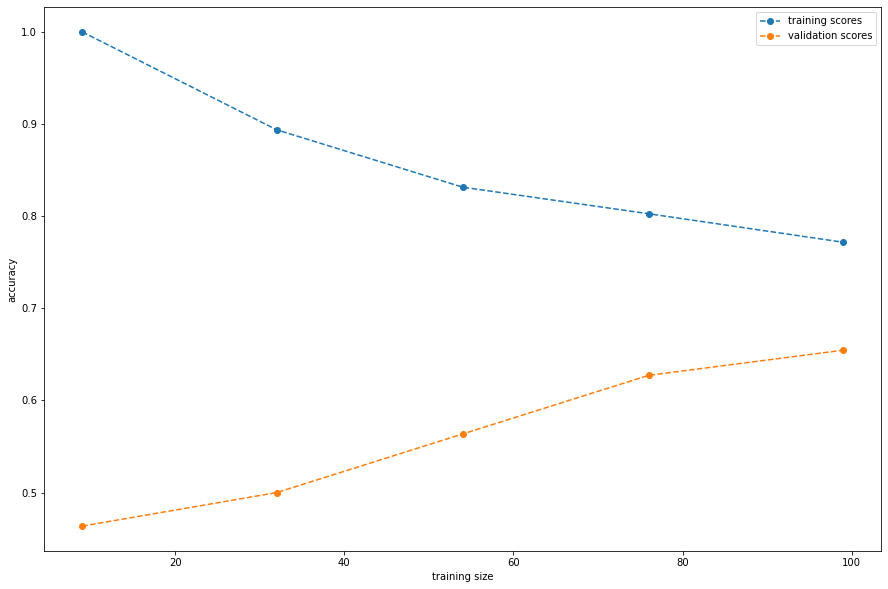

In [34]:
# Learning curve for Ag_100nm_AuNPs as it has the best performance
from sklearn.model_selection import learning_curve

# plot learning curve 

key_set = 'Ag_100nm_AuNPs'
train_sizes, train_scores, valid_scores = learning_curve(KNeighborsClassifier(), x_pca[key_set], y[key_set], train_sizes = np.linspace(0.1, 1.0, 5), scoring = 'accuracy', cv=int(K))
train_scores_mean = train_scores.mean(axis = 1)
valid_scores_mean = valid_scores.mean(axis = 1)
plt.figure(figsize = [15,10])
plt.plot(train_sizes, train_scores_mean, "o--", label = 'training scores')
plt.plot(train_sizes, valid_scores_mean, "o--", label = 'validation scores')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('training size')


Text(0.5, 0, 'training size')

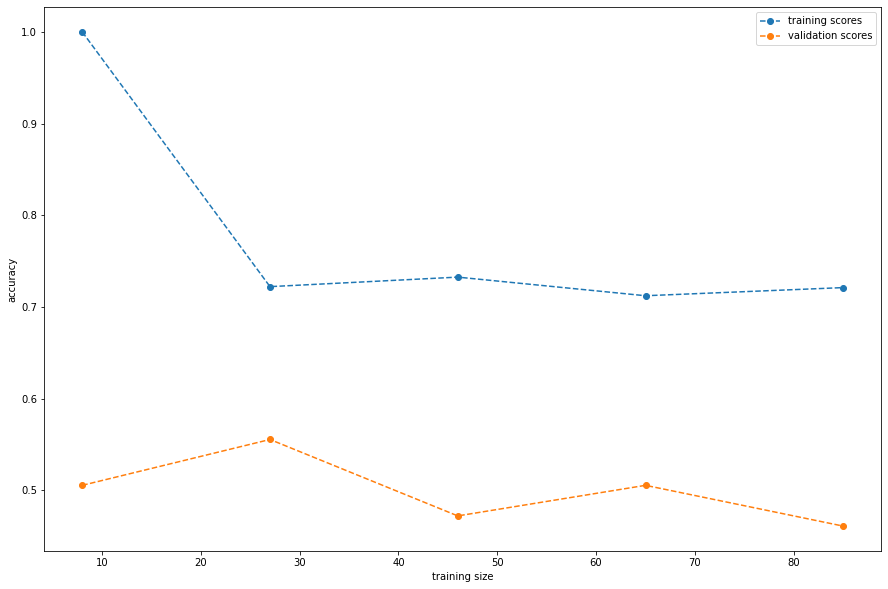

In [35]:
# Learning curve for Al_tape_60nm_AuNPs as it has the worst performance
from sklearn.model_selection import learning_curve

# plot learning curve 

key_set = 'Al_tape_60nm_AuNPs'
train_sizes, train_scores, valid_scores = learning_curve(KNeighborsClassifier(), x_pca[key_set], y[key_set], train_sizes = np.linspace(0.1, 1.0, 5), scoring = 'accuracy', cv=int(K))
train_scores_mean = train_scores.mean(axis = 1)
valid_scores_mean = valid_scores.mean(axis = 1)
plt.figure(figsize = [15,10])
plt.plot(train_sizes, train_scores_mean, "o--", label = 'training scores')
plt.plot(train_sizes, valid_scores_mean, "o--", label = 'validation scores')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('training size')

### cross_val_score for data from Python

In [36]:
# cross_val_score for data from Python and MATLAB
# a and b in the loop are just for easy naming
from sklearn.model_selection import cross_val_score
for key_model in models_dict.keys():
    # Au_100nm_AuNPs
    a_python = cross_val_score(models_dict[key_model], x_pca_2['Au_100nm_AuNPs'], y['Au_100nm_AuNPs'],cv=K).mean()
    # Ag_100nm_AgNPs
    b_python = cross_val_score(models_dict[key_model], x_pca_2['Ag_100nm_AgNPs'], y['Ag_100nm_AgNPs'],cv=K).mean()
    # print scores
    print(f'A) accuracy for Au_100nm_AuNPs python {round(a_python,2)}')
    print(f'B) accuracy for Ag_100nm_AgNPs python {round(b_python,2)}')

NameError: name 'x_pca_2' is not defined

### Optimize KNN clasifier

In [ ]:
# optimize KNN by changing number of neighbors
key_set = 'Ag_100nm_AuNPs'

for i in range(1,15):
    auc_values_KNN_cv = round(cross_val_score(KNeighborsClassifier(i), x_pca[key_set], y[key_set],cv=K, scoring = 'roc_auc').mean(),3)
    acc_values_KNN_cv = round(cross_val_score(KNeighborsClassifier(i), x_pca[key_set], y[key_set],cv=K, scoring = 'accuracy').mean(),3)

    print(f'KNN accuracy for {i} neighbors and accuracy value {acc_values_KNN_cv} and AUC {auc_values_KNN_cv} and theirs sum {round(auc_values_KNN_cv+acc_values_KNN_cv,3)}')